# Skin Cancer Detection

### 1. Importing Libraries

In [1]:
# for data manipulation
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D , MaxPooling2D ,Dropout , Flatten , Dense ,BatchNormalization ,Concatenate ,Input 
from keras.models import Sequential ,Model

# SK Learn library to split train and test data
from sklearn.model_selection import train_test_split

# other libraries
import cv2
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [2]:
# loading the csv file

metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
label_mapping = {
    "bkl": 0,
    "nv": 1,
    "df": 2,
    "mel": 3,
    "vasc": 4,
    "bcc": 5,
    "akiec": 6
}

### 2. Loading Images

In [4]:
# # Deleting Folder
# import shutil
# shutil.rmtree("/kaggle/working/")

In [5]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

# Directories for images
image_folder1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_folder2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

# Initialize lists for image data and labels
segmented_image_data = []
labels2 = []

# Function to segment an image
def segment_image(image_path):
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        return None  # Return None if the image could not be loaded

    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    
    # Draw contours
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
    
    # Apply mask to isolate lesion
    segmented = cv2.bitwise_and(image, image, mask=mask)
    
    return segmented

# Process images and labels
for idx, row in metadata.iterrows():
    image_id = row['image_id']
    dx = row['dx']
    
    # Construct the image path for each folder
    image_path1 = f"{image_folder1}/{image_id}.jpg"
    image_path2 = f"{image_folder2}/{image_id}.jpg"
    
    # Try to load and segment the image
    image = None
    if os.path.exists(image_path1):
        image = segment_image(image_path1)
    elif os.path.exists(image_path2):
        image = segment_image(image_path2)
    
    # If the image couldn't be loaded, skip it
    if image is None:
        print(f"Image not found or could not be read: {image_id}")
        continue

    # Resize the segmented image to the model's input size
    image = cv2.resize(image, (192, 192))
    image = img_to_array(image) / 255.0  # Normalize image to [0, 1]
    segmented_image_data.append(image)
    
    # Append labels
    # labels1.append(label_mapping[dx])
    labels2.append(label_mapping[dx])

# Convert to NumPy arrays
X_segmented = np.array(segmented_image_data)
y_segmented = np.array(labels2)  # Assuming `label_mapping2` is for y

print(f"Total segmented images processed: {len(X_segmented)}")
print(f"Shape of X_segmented: {X_segmented.shape}")
print(f"Shape of y_segmented: {y_segmented.shape}")

Total segmented images processed: 10015
Shape of X_segmented: (10015, 192, 192, 3)
Shape of y_segmented: (10015,)


In [6]:
y_encoded = pd.get_dummies(y_segmented, dtype=int).values
print(f"Shape of y_segmented: {y_encoded.shape}")
y_encoded

Shape of y_segmented: (10015, 7)


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
X_train_image, X_test_image, y_encoded_train ,y_encoded_test = train_test_split(X_segmented, y_encoded ,test_size=.2 ,random_state=42)

### 3. Model Implementation

#### i. EfficientNet - base model (no trainable parameters)

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [9]:
# Loading the EfficientNetB0 model pre-trained on ImageNet
base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Freezing the base model
base_model1.trainable = False

In [11]:
# model adjustments

# Adding custom classification head
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  # Dropout to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(7, activation='softmax')(x)  # 7 output labels

# and defining the final model
model1 = Model(inputs=base_model1.input, outputs=output)

In [12]:
# Compiling the model
model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 192,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 192, 192,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 192, 192,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 192, 192,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 193, 193,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 96, 96,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 96, 96,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 96, 96,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 96, 96,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 96, 96,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 96, 96,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 96, 96,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 96, 96,    │        512 │ block1a_se_excit

 Total params: 4,411,306 (16.83 MB)

 Trainable params: 361,735 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
# # Training the model
# history = model1.fit(
#     X_train_image, y_encoded_train,
#     validation_data=(X_test_image, y_encoded_test),
#     epochs=25,
#     batch_size=8
# )

#### ii. EfficientNet - Hyperparameter Tuned (Trainable Parameters)

In [15]:
# Fine-tuning the model (unfreeze some layers of the base model)
base_model1.trainable = True

# Lowering the learning rate for fine-tuning
model1.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_finetune = model1.fit(
    X_train_image, y_encoded_train,
    validation_data=(X_test_image, y_encoded_test),
    epochs=10,
    batch_size=16
)

Epoch 1/10


I0000 00:00:1732044608.345900      70 service.cc:145] XLA service 0x7839b0077d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732044608.345953      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732044608.345960      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/501 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.0469 - loss: 2.2873    

I0000 00:00:1732044654.103013      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


501/501 ━━━━━━━━━━━━━━━━━━━━ 155s 158ms/step - accuracy: 0.6066 - loss: 1.1378 - val_accuracy: 0.5247 - val_loss: 1.4837
Epoch 2/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.7692 - loss: 0.6530 - val_accuracy: 0.7783 - val_loss: 0.6126
Epoch 3/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.8079 - loss: 0.5095 - val_accuracy: 0.7943 - val_loss: 0.5784
Epoch 4/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.8497 - loss: 0.4065 - val_accuracy: 0.8073 - val_loss: 0.5813
Epoch 5/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.8847 - loss: 0.3058 - val_accuracy: 0.7958 - val_loss: 0.5954
Epoch 6/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.9101 - loss: 0.2541 - val_accuracy: 0.8093 - val_loss: 0.5692
Epoch 7/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.9398 - loss: 0.1845 - val_accuracy: 0.8293 - val_loss: 0.6066
Epoch 8/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.9467 - loss: 0.1518 - val_accur

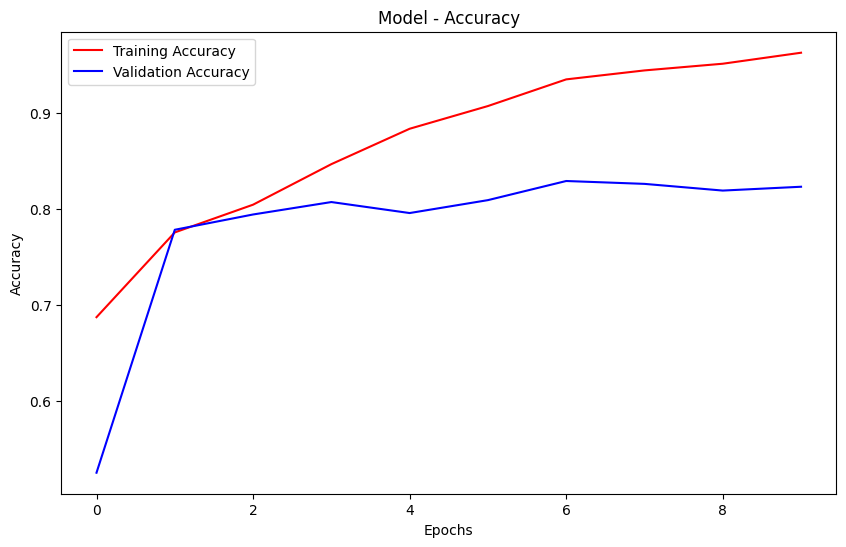

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history_finetune.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model - Accuracy')
plt.show()